<a href="https://colab.research.google.com/github/how-to-train-your-model/data-science-portfolio/blob/main/Module_9_Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 8: Dogs vs. Cats Redux: Kernel Edition 

### Author: Pankaj Pant









Importing Packages

# Import Packages

In [1]:
!pip install pathlib2
import os
from pathlib2 import Path
import zipfile
from zipfile import ZipFile
import time
import string


import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from tqdm import tqdm
from PIL import Image, ImageFilter
from IPython.display import display
import cv2

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
import re


from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


import tensorflow as tf
from tensorflow import keras



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
# Allows for muliple output in one cell window
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Allows for viewing the complete data in a single window 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data Ingestion
### Connect to google drive and import training and test data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls -l "/content/drive/My Drive/Colab_Notebooks/MSDS-422/W9"

total 2154
-rw------- 1 root root 730265 Mar  5 14:36  Module9_Assignment1_Group5.ipynb
-rw------- 1 root root    143 Mar  5 22:28 'Module 9: Natural Language Processing with Disaster Tweets.gdoc'
-rw------- 1 root root  42005 Mar  5 23:36 'Module 9: Natural Language Processing with Disaster Tweets.ipynb'
-rw------- 1 root root  22746 Dec 17  2019  sample_submission.csv
-rw------- 1 root root 420783 Dec 17  2019  test.csv
-rw------- 1 root root 987712 Dec 17  2019  train.csv


In [7]:
#Generalize the file path 
w9_files = "/content/drive/My Drive/Colab_Notebooks/MSDS-422/W9"

## Data Extraction

In [8]:
#Create dataframe
train_df = pd.read_csv(w9_files+"/train.csv")

test_df = pd.read_csv(w9_files+"/test.csv")

print("Shape of train and test dataset :" , train_df.shape ,test_df.shape)

Shape of train and test dataset : (7613, 5) (3263, 4)


# EDA

In [9]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train_df[train_df['keyword'].isna()].shape

(61, 5)

In [11]:
train_df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [12]:
loc1 = train_df['location'].unique()
#train_df[train_df['location'].str.contains('$')].head()
loc1[:15]

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India'], dtype=object)

In [13]:
train_df.isnull().sum()/(train_df['target'].count())*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [14]:
train_df.isnull().sum().sum()
print('\n')
test_df.isnull().sum().sum()

2594

1131

In [15]:
train_df['target'].value_counts()/train_df['target'].count()
#train_df['target'].count()

0    0.57034
1    0.42966
Name: target, dtype: float64

In [16]:
train_df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


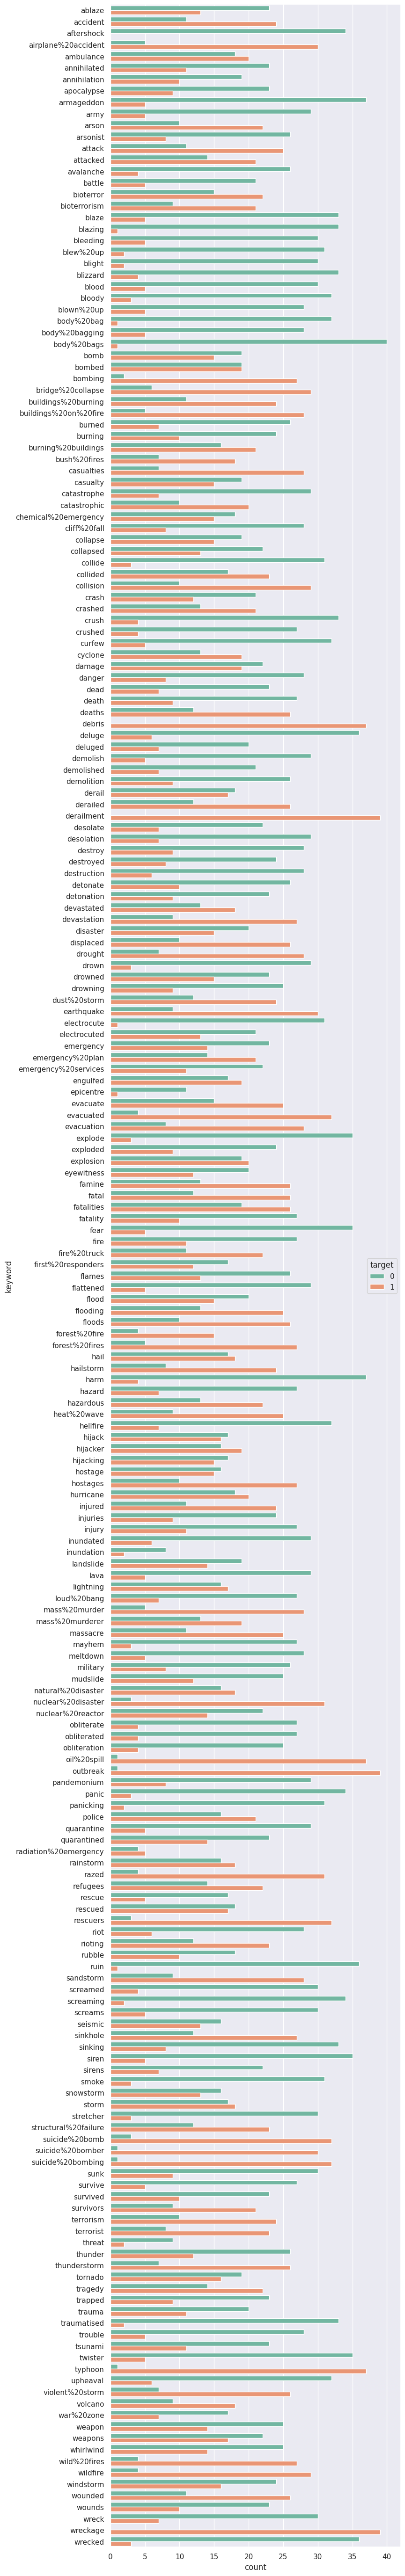

In [17]:
# Checking keywords and their occurance with resoect to the target variable
fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(y=train_df['keyword'], hue= train_df['target'], palette="Set2")

In [18]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
#train_df = pd.read_csv(w9_files+"/train.csv")

#test_df = pd.read_csv(w9_files+"/test.csv")

In [20]:
train_df['text_len'] = train_df['text'].map(len)


In [21]:
train_df.head()
train_df.groupby(['target']).agg({ 'text_len' : ['min', 'max','mean']})

,id,keyword,location,text,target,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


text_len                 
            min  max        mean
target                          
0             7  157   95.706817
1            14  151  108.113421

# Data cleansing

In [22]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

In [23]:
# Decontraction
def decontracted(phrase):
    # Specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # General
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
# combined dataframe for data preprocessing
combined_df = pd.concat([train_df, test_df])
combined_df.shape

(10876, 6)

In [25]:
combined_df['text'] = train_df['text'].apply(lambda x: decontracted(x))
combined_df.text.head(5)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to  ishelter in place' are...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [26]:
import nltk
nltk.download('punkt')

def clean_text(each_text):

    # remove URL from text
    each_text_no_url = re.sub(r"http\S+", "", each_text)
    
    # remove numbers from text
    text_no_num = re.sub(r'\d+', '', each_text_no_url)

    # tokenize each text
    word_tokens = word_tokenize(text_no_num)
    
    # remove sptial character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
  
    
    return " ".join(" ".join(stemmed_text).split())
    #return " ".join(" ".join(text_with_no_stop_word ).split()) 



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
combined_df['clean_text'] = combined_df['text'].apply(lambda x: clean_text(x))
combined_df['keyword'] = combined_df['keyword'].fillna("none")
combined_df['clean_keyword'] = combined_df['keyword'].apply(lambda x: clean_text(x) )

In [28]:
combined_df['location'] = combined_df['location'].fillna("none")
combined_df['clean_location'] = combined_df['location'].apply(lambda x: clean_text(x) )
combined_df.head()

,id,keyword,location,text,target,text_len,clean_text,clean_keyword,clean_location
0,1,none,none,Our Deeds are the Reason of this #earthquake M...,1.0,69.0,our deed reason earthquak may allah forgiv us,none,none
1,4,none,none,Forest fire near La Ronge Sask. Canada,1.0,38.0,forest fire near la rong sask canada,none,none
2,5,none,none,All residents asked to ishelter in place' are...,1.0,133.0,all resid ask ishelt place notifi offic no eva...,none,none
3,6,none,none,"13,000 people receive #wildfires evacuation or...",1.0,65.0,peopl receiv wildfir evacu order california,none,none
4,7,none,none,Just got sent this photo from Ruby #Alaska as ...,1.0,88.0,just got sent photo rubi alaska smoke wildfir ...,none,none


In [29]:
type(combined_df['clean_text'])

pandas.core.series.Series

In [30]:
# Combining column 'clean_keyword' and 'clean_text' into one
combined_df['keyword_text'] = combined_df['clean_keyword'] + " " + combined_df['clean_text']

In [31]:
#doc = combined_df["clean_text"]
doc = combined_df['keyword_text'] 

In [32]:
new_tokenizer = tf.keras.preprocessing.text.Tokenizer()
new_tokenizer.fit_on_texts(doc)

In [33]:
new_tokens = new_tokenizer.texts_to_sequences(doc)
new_tokens[:1]
type(new_tokens)

[[211, 607, 4077, 538, 128, 173, 1761, 2509, 38]]

list

In [34]:
padding_tokens=tf.keras.preprocessing.sequence.pad_sequences(new_tokens,
                                                               maxlen=30,
                                                               padding='post',
                                                               truncating='post')


In [35]:
padding_tokens.shape

(10876, 30)

In [36]:
padding_tokens

array([[ 211,  607, 4077, ...,    0,    0,    0],
       [ 211,  115,    3, ...,    0,    0,    0],
       [ 211,  258, 1762, ...,    0,    0,    0],
       ...,
       [ 211, 1237,  177, ...,    0,    0,    0],
       [ 211,  261,  446, ...,    0,    0,    0],
       [ 211, 8642,  427, ...,    0,    0,    0]], dtype=int32)

In [37]:
disaster_label = train_df['target']
train_data = train_df.drop(['target'], axis =1)

In [38]:
X_train_t = padding_tokens[:len(train_data)]
y_train_t = disaster_label

test_df = pd.read_csv(w9_files+"/test.csv")
X_test = padding_tokens[:len(test_df)]


In [39]:
print(combined_df.shape,train_data.shape, disaster_label.shape, test_df.shape)
print(X_train_t.shape, y_train_t.shape, X_test.shape)

(10876, 10) (7613, 5) (7613,) (3263, 4)
(7613, 30) (7613,) (3263, 30)


# Train Validation Split

In [40]:
combined_df.head()
combined_df['clean_keyword'].unique()

,id,keyword,location,text,target,text_len,clean_text,clean_keyword,clean_location,keyword_text
0,1,none,none,Our Deeds are the Reason of this #earthquake M...,1.0,69.0,our deed reason earthquak may allah forgiv us,none,none,none our deed reason earthquak may allah forgi...
1,4,none,none,Forest fire near La Ronge Sask. Canada,1.0,38.0,forest fire near la rong sask canada,none,none,none forest fire near la rong sask canada
2,5,none,none,All residents asked to ishelter in place' are...,1.0,133.0,all resid ask ishelt place notifi offic no eva...,none,none,none all resid ask ishelt place notifi offic n...
3,6,none,none,"13,000 people receive #wildfires evacuation or...",1.0,65.0,peopl receiv wildfir evacu order california,none,none,none peopl receiv wildfir evacu order california
4,7,none,none,Just got sent this photo from Ruby #Alaska as ...,1.0,88.0,just got sent photo rubi alaska smoke wildfir ...,none,none,none just got sent photo rubi alaska smoke wil...


array(['none', 'ablaz', 'accid', 'aftershock', 'airplan accid', 'ambul',
       'annihil', 'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist',
       'attack', 'avalanch', 'battl', 'bioterror', 'blaze', 'bleed',
       'blew', 'blight', 'blizzard', 'blood', 'bloodi', 'blown',
       'bodi bag', 'bomb', 'bridg collaps', 'build burn', 'build fire',
       'burn', 'burn build', 'bush fire', 'casualti', 'catastroph',
       'chemic emerg', 'cliff fall', 'collaps', 'collid', 'collis',
       'crash', 'crush', 'curfew', 'cyclon', 'damag', 'danger', 'dead',
       'death', 'debri', 'delug', 'demolish', 'demolit', 'derail',
       'desol', 'destroy', 'destruct', 'deton', 'devast', 'disast',
       'displac', 'drought', 'drown', 'dust storm', 'earthquak',
       'electrocut', 'emerg', 'emerg plan', 'emerg servic', 'engulf',
       'epicentr', 'evacu', 'explod', 'explos', 'eyewit', 'famin',
       'fatal', 'fear', 'fire', 'fire truck', 'first respond', 'flame',
       'flatten', 'flood', 'fo

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_t, 
                                                      y_train_t,
                                                      test_size = 0.2, 
                                                      random_state = 60,
                                                      shuffle=True)

print(len(X_train) , len(X_valid), len(y_train), len(y_valid))

6090 1523 6090 1523


# M1 - LSTM with no dropout

In [42]:
num_words = len(new_tokenizer.index_word) + 1
max_content_length = 30
tf.keras.backend.clear_session()
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 128, input_length=max_content_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(1, activation='sigmoid')])
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           1789824   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          263168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
history1 = model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, callbacks=[early_stop])

Epoch 1/20
191/191 [==============================] - 15s 20ms/step - loss: 0.8832 - accuracy: 0.7122 - val_loss: 0.6151 - val_accuracy: 0.7866
Epoch 2/20
191/191 [==============================] - 2s 12ms/step - loss: 0.3991 - accuracy: 0.8681 - val_loss: 0.5453 - val_accuracy: 0.7715
Epoch 3/20
191/191 [==============================] - 2s 12ms/step - loss: 0.2560 - accuracy: 0.9215 - val_loss: 0.6779 - val_accuracy: 0.7774
Epoch 4/20
191/191 [==============================] - 2s 12ms/step - loss: 0.2038 - accuracy: 0.9455 - val_loss: 0.6789 - val_accuracy: 0.7695
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.1738 - accuracy: 0.9539 - val_loss: 0.7608 - val_accuracy: 0.7439
Epoch 6/20
191/191 [==============================] - 3s 17ms/step - loss: 0.1553 - accuracy: 0.9611 - val_loss: 0.8174 - val_accuracy: 0.7531
Epoch 7/20
191/191 [==============================] - 3s 18ms/step - loss: 0.1358 - accuracy: 0.9644 - val_loss: 0.6725 - val_accuracy: 0.771

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

<Figure size 432x288 with 0 Axes>

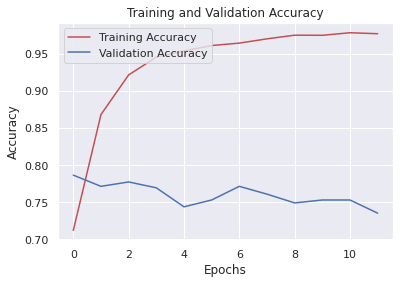

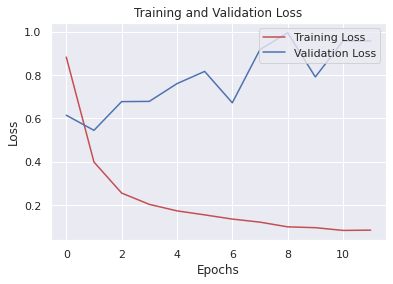

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history1.history['accuracy']
val_acc=history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.figure()

In [45]:
y_val_pred = np.array(model1.predict(X_valid) > 0.5, dtype=int).reshape(-1)

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_val_pred)

In [47]:
print(classification_report(y_valid, y_val_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       886
           1       0.69      0.67      0.68       637

    accuracy                           0.74      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.73      0.74      0.73      1523



Text(0.5, 1.05, 'Confusion Matrix : Actual v/s Predicted')

Text(0.5, 12.5, 'Predicted Value')

Text(30.5, 0.5, 'Actual Value')

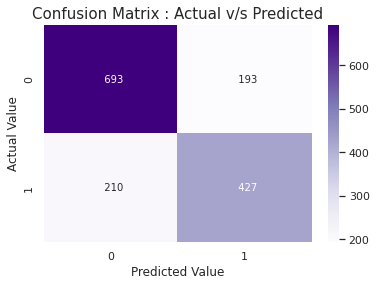

In [48]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_valid, y_val_pred),annot=True,fmt='5.0f',cmap="Purples")
plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
#ax = fig.add_subplot(111)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

In [49]:
#Fitting on test dataset
y_test = np.array(model1.predict(X_test) > 0.5, dtype=int).reshape(-1)

## Kaggle Submission 1

In [50]:
sub1 = pd.DataFrame({"id": test_df["id"], "target": y_test})

In [51]:
sub1.to_csv("disaster_tweet_sub1.csv", index=False)

Clearly our model is overfitting as the train accuracy is increasing at a much faster pace compared to validation accuracy. We will add recurrent drop out layer to improve it. The Kaggle score is 0.56 indicating that the model perfomance is as good as a random guess.

# M2 - LSTM with recurrent drop out

In [52]:
num_words = len(new_tokenizer.index_word) + 1
max_content_length = 30
tf.keras.backend.clear_session()
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 128, input_length=max_content_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           1789824   
                                                                 
 conv1d (Conv1D)             (None, 26, 128)           82048     
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,085,953
Trainable params: 2,085,953
Non-

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
#history2 = model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, callbacks=[early_stop])
history2 = model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)


Epoch 1/20
191/191 [==============================] - 39s 154ms/step - loss: 1.0111 - accuracy: 0.6882 - val_loss: 0.5586 - val_accuracy: 0.7643
Epoch 2/20
191/191 [==============================] - 29s 150ms/step - loss: 0.4715 - accuracy: 0.8330 - val_loss: 0.5640 - val_accuracy: 0.7571
Epoch 3/20
191/191 [==============================] - 30s 155ms/step - loss: 0.4296 - accuracy: 0.8516 - val_loss: 0.5820 - val_accuracy: 0.7735
Epoch 4/20
191/191 [==============================] - 28s 148ms/step - loss: 0.3062 - accuracy: 0.9105 - val_loss: 0.6097 - val_accuracy: 0.7617
Epoch 5/20
191/191 [==============================] - 29s 153ms/step - loss: 0.2205 - accuracy: 0.9432 - val_loss: 0.6217 - val_accuracy: 0.7610
Epoch 6/20
 90/191 [=============>................] - ETA: 14s - loss: 0.1639 - accuracy: 0.9625

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.figure()

In [ ]:
y_val_pred = np.array(model2.predict(X_valid) > 0.5, dtype=int).reshape(-1)

In [ ]:
print(classification_report(y_valid, y_val_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_valid, y_val_pred),
            annot=True,fmt='5.0f',cmap="Purples")
plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
#ax = fig.add_subplot(111)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

In [ ]:
#Fitting on test dataset
y_test = np.array(model2.predict(X_test) > 0.5, dtype=int).reshape(-1)

## Kaggle Submission 2

In [ ]:
sub2 = pd.DataFrame({"id": test_df["id"], "target": y_test})

In [ ]:
sub2.to_csv("disaster_tweet_sub2.csv", index=False)

This model fits better than experiment 1. The F1 score for target group 1 is 0.7. The Kaggle score for the test dataset is 0.76064 indicating a better fit.However, the model is still overfitting on train dataset.

# M3 - Bidirectional LSTM with recurrent drop out and dropout  

In [ ]:
num_words = len(new_tokenizer.index_word) + 1
max_content_length = 30
tf.keras.backend.clear_session()
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 80, input_length=max_content_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2,return_sequences=True)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
#history3 = model3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, callbacks=[early_stop,learning_rate_reduction])
history3 = model3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, callbacks=[learning_rate_reduction])

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.figure()

In [ ]:

# Evaluate the model
predicted = model3.predict(X_valid, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model3.evaluate(X_valid, y_valid, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_valid), y_predicted))

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_valid, y_val_pred),annot=True,
            fmt='5.0f',cmap="Purples")
plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
#ax = fig.add_subplot(111)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

## Kaggle Submission 3

In [ ]:
#Fitting on test dataset
y_test3 = np.array(model3.predict(X_test) > 0.5, dtype=int).reshape(-1)

In [ ]:
sub3 = pd.DataFrame({"id": test_df["id"], "target": y_test3})

In [ ]:
sub3.to_csv("disaster_tweet_sub3.csv", index=False)

The model continues to overfit on train dataset, the test dataset Kaggle score was only 0.57033 testament to the overfitting issue.

# M4: Bidirectional with four layers and four dropouts

In [ ]:
num_words = len(new_tokenizer.index_word) + 1
max_content_length = 30
tf.keras.backend.clear_session()
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 120, input_length=max_content_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, dropout=0.5, recurrent_dropout=0.2,return_sequences=True)),
    tf.keras.layers.LSTM(80),
    #tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(16, activation = 'relu'),
    #tf.keras.layers.Dropout(0.5),   
    #tf.keras.layers.Dense(8, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    #tf.keras.layers.Dense(4, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model4.summary()


In [ ]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
history4 = model4.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, callbacks=[early_stop,learning_rate_reduction])


In [ ]:
y_val_pred = np.array(model4.predict(X_valid) > 0.5, dtype=int).reshape(-1)

In [ ]:
print(classification_report(y_valid, y_val_pred))

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history4.history['accuracy']
val_acc=history4.history['val_accuracy']
loss=history4.history['loss']
val_loss=history4.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.figure()

In [ ]:

# Evaluate the model
predicted = model4.predict(X_valid, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model4.evaluate(X_valid, y_valid, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_valid), y_predicted))

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_valid, y_val_pred),annot=True,
            fmt='5.0f',cmap="Purples")
plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
#ax = fig.add_subplot(111)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

## Kaggle Submission 4

In [ ]:
#Fitting on test dataset
y_test4 = np.array(model4.predict(X_test) > 0.5, dtype=int).reshape(-1)

In [ ]:
sub4 = pd.DataFrame({"id": test_df["id"], "target": y_test4})

In [ ]:
sub4.to_csv("disaster_tweet_sub4.csv", index=False)

# M5: RNN model with LSTM and Bidirectional Structure 

In [ ]:
!pip install Adam


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, Dense, CuDNNLSTM, concatenate, Bidirectional, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
#from keras.optimizers import 
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from sklearn.model_selection import KFold

import tensorflow as tf

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Allows for muliple output in one cell window
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Allows for viewing the complete data in a single window 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
import re
def punct_apo_fix(x):
  x = str(x)
  x = x.replace("_"," ")
  for punct in "`’":
    x = x.replace(punct,"'")
    for punct in '!,?()%":.$“/;#+*=&gt;[]&amp;-':
      x = x.replace(punct, f' {punct} ')
      apos = re.findall("'.*?[\s]", x)
      for apo in apos:
        if apo.lower() in ["'t ","'re ", "' ", "'ve ", "'s ", "'ll ", "'d ", "'n ", "'clock ", "'m "]:
          x = x.replace(apo, f' {apo}')
        else:
          x = x.replace(apo, f" ' {apo[1:]}")
        if (x.endswith("'")):
          x = x[:-1]+" '"
  return x

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#w9_files = "/content/drive/My Drive/Colab_Notebooks/MSDS-422/W9"

#Create dataframe
df_train = pd.read_csv(w9_files+"/train.csv")
df_test = pd.read_csv(w9_files+"/test.csv")

print("Shape of train and test dataset :" , train_df.shape ,test_df.shape)

In [ ]:
df_train.head()
df_test.head()

In [ ]:
df_merge = pd.concat([df_train[['id','text']], df_test], axis=0)
df_merge["comment_text"] = df_merge["text"].apply(lambda x: punct_apo_fix(x))
df_train_comment = df_merge.iloc[:df_train.shape[0],:]
df_test_comment = df_merge.iloc[df_train.shape[0]:,:]
df_train_comment = pd.concat([df_train_comment,df_train[['target']]],axis=1)

In [ ]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
df_train_comment['target'] = np.where(df_train_comment['target'] >= 0.5, True, False)
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(list(df_train_comment['comment_text']) + list(df_test_comment['comment_text']))
total_unique_word = len(tokenizer.word_index) + 1
wordvectors_index = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'))
#wv_from_text = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)  # C text format


In [ ]:
EMBEDDINGS_DIMENSION = 10
embedding_matrix = np.zeros((total_unique_word,EMBEDDINGS_DIMENSION))
for word, i in tokenizer.word_index.items():
  if word in wordvectors_index.vocab:
    embedding_matrix[i] = wordvectors_index[word]

In [ ]:
MAX_SEQUENCE_LENGTH = 256
def build_model(total_unique_word, embedding_matrix):
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedding_layer = Embedding(total_unique_word,
  EMBEDDINGS_DIMENSION,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False)
  x = embedding_layer(sequence_input)
  x = SpatialDropout1D(0.2)(x)
  x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
  x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
  avg_pool1 = GlobalAveragePooling1D()(x)
  max_pool1 = GlobalMaxPooling1D()(x)
  x = concatenate([avg_pool1, max_pool1])
  preds = Dense(1, activation='sigmoid')(x)
  model = Model(sequence_input, preds)
  model.compile(loss='binary_crossentropy',
  #optimizer=Adam(),
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
  metrics=['acc'])
  return model

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
train_text = pad_sequences(tokenizer.texts_to_sequences(df_train_comment["text"]), maxlen=MAX_SEQUENCE_LENGTH)
test_text = pad_sequences(tokenizer.texts_to_sequences(df_test_comment["text"]), maxlen=MAX_SEQUENCE_LENGTH)
train_target = df_train_comment["target"]
n_splits=3
splits = list(KFold(n_splits).split(train_text,train_target))
test_preds = np.zeros((df_test_comment.shape[0]))
for fold in list(range(n_splits)):
  K.clear_session()
  tr_ind, val_ind = splits[fold]
  #checkpoint = ModelCheckpoint(f'gru_{fold}.hdf5', save_best_only = True)
  #earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
  early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
  model = build_model(total_unique_word,embedding_matrix)
  model.fit(train_text[tr_ind],train_target[tr_ind],
            #batch_size=1024,
            epochs=20,
            validation_data=(train_text[val_ind], train_target[val_ind]),
            callbacks=[early_stop,learning_rate_reduction])
  test_preds += model.predict(test_text)[:,0]
test_preds /= n_splits


In [ ]:
submission = pd.read_csv(w9_files+"/sample_submission.csv", index_col='id')
submission['prediction'] = test_preds
submission.reset_index(drop=False, inplace=True)



In [ ]:
validation_df = pd.merge(df_test, submission, on='id')
validation_df[validation_df.prediction > 0.5].head()
validation_df[validation_df.prediction < 0.5].head()

In [ ]:
validation_df.head()

## Kaggle Submission 5

In [ ]:
y_test5 = np.array(validation_df.prediction > 0.5, dtype=int).reshape(-1)

In [ ]:
sub5 = pd.DataFrame({"id": df_test["id"], "target": y_test5})

In [ ]:
sub5.to_csv("disaster_tweet_sub5.csv", index=False)